# Smash Bros Ultimate Online Analysis
This notebook analyzes the data for all matches played on smash.gg where their characters or stage were recorded

In [1]:
import numpy as np
import pandas as pd
import plotnine
from plotnine import *

In [2]:
games_df = pd.read_csv('game_data.csv', index_col=0)
games_df.head()

/home/heil/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,char1,char2,stage,winner,entrant1,entrant2
0,Lucina,Ness,Pokémon Stadium 2,Ness,KG | Jegerlilla,RES | Venom
1,Ness,Lucina,Smashville,Ness,RES | Venom,KG | Jegerlilla
2,Ness,Lucina,Battlefield,Ness,RES | Venom,KG | Jegerlilla
3,Banjo-Kazooie,Young Link,Final Destination,Banjo-Kazooie,RoA | Irish_Penguin,LazZzy
4,Banjo-Kazooie,Young Link,Final Destination,Banjo-Kazooie,RoA | Irish_Penguin,LazZzy


## Most Popular Character/Stage
To better understand the data, the first step is to count the frequencies of each character and stage

In [3]:
games_df['stage'].value_counts()

Pokémon Stadium 2       472921
Town and City           211441
Final Destination       210111
Smashville              200474
Battlefield             191275
Kalos Pokémon League    112274
Yoshi's Story            50056
Lylat Cruise             30689
Yoshi's Island           12410
Pokémon Stadium           5010
Unova Pokémon League      3428
Castle Siege              1568
WarioWare, Inc.            250
Frigate Orpheon             75
Skyloft                     60
Magicant                    23
Mario Circuit               12
Name: stage, dtype: int64

### Stage Results:
Unsurprisingly, the top five stages are the five starting stages in modern rulesets. Other well-represented stages are stages [that were legal in the past.](https://smash.gg/tournament/ultimate-naifu-wars-1/details)

In [4]:
char_totals = games_df['char1'].value_counts() + games_df['char2'].value_counts()
sorted_totals = char_totals.sort_values(ascending=False)
for count, char in zip(sorted_totals, sorted_totals.index):
    print('{}\t\t\t{}'.format(char, count))

Joker			97261
Ness			93407
Bowser			92786
Cloud			91897
Wolf			90590
Palutena			90302
Pokemon Trainer			88108
Inkling			82387
Snake			80150
Yoshi			74886
R.O.B.			72657
Mario			62283
Lucina			60704
Donkey Kong			59285
Luigi			56774
Link			56246
Sonic			55239
Pikachu			54586
Zelda			51639
Ganondorf			51106
Captain Falcon			47774
Mr. Game and Watch			47143
Ike			46715
Roy			45121
Jigglypuff			44593
Terry			44541
King Dedede			44411
Pac-Man			44280
King K. Rool			43623
Young Link			43584
Banjo-Kazooie			43573
Samus			42057
Lucas			41459
Greninja			39924
Zero Suit Samus			38570
Hero			37062
Little Mac			36779
Wii Fit Trainer			36343
Kirby			31249
Chrom			30613
Piranha Plant			29649
Fox			29195
Toon Link			28671
Ridley			28191
Pichu			27808
Shulk			27791
Bowser Jr.			26543
Robin			26176
Mega Man			26099
Bayonetta			26061
Ken			25764
Peach			25459
Falco			24732
Incineroar			23099
Wario			22178
Richter			21925
Byleth			21354
Random			21193
Diddy Kong			20978
Isabelle			20938
Dr. Mario			20375

### Character Results


In [5]:
char_to_index = {}

i = 0
for char in games_df['char1']:
    if char not in char_to_index:
        char_to_index[char] = i
        i += 1
print(len(char_to_index))

83


In [6]:
# format = winner: loser: count
wins_map = {}

for _, row in games_df.iterrows():
    char1 = row['char1']
    char2 = row['char2']
    
    char1_is_winner = row['char1'] == row['winner']
    
    if not char1_is_winner:
        char1, char2 = (char2, char1)
        
    if char1 not in wins_map:
        wins_map[char1] = {}
        wins_map[char1][char2] = 1
    elif char2 not in wins_map[char1]:
        wins_map[char1][char2] = 1
    else:
        wins_map[char1][char2] += 1

In [7]:
matchup_info = {'char1': [], 
                'char2': [],
                'win_rate': [],
                'games_played': []
               }
char_to_win_rate = {}
for char1 in wins_map:
    char_win_rates = []
    for char2 in wins_map[char1]:
        matchup_info['char1'].append(char1)
        matchup_info['char2'].append(char2)
        
        games_played = wins_map[char1][char2]
        try:
            games_played += wins_map[char2][char1]
        except KeyError:
            pass
        
        win_rate = wins_map[char1][char2] / games_played
        char_win_rates.append(win_rate)
        
        matchup_info['win_rate'].append(win_rate)
        matchup_info['games_played'].append(games_played)
    char_to_win_rate[char1] = sum(char_win_rates) / len(char_win_rates)
    
for key in matchup_info:
    print(key, len(matchup_info[key]))
matchup_df = pd.DataFrame.from_dict(matchup_info)
matchup_df

char1 6822
char2 6822
win_rate 6822
games_played 6822


,char1,char2,win_rate,games_played
0,Ness,Lucina,0.568889,2250
1,Ness,Piranha Plant,0.518605,860
2,Ness,Mario,0.532323,1980
3,Ness,Shulk,0.482467,827
4,Ness,Pokemon Trainer,0.547465,2623
...,...,...,...,...
6817,NaN,Samus,0.014085,142
6818,NaN,Random,0.025000,40
6819,NaN,Mario,0.004878,205
6820,NaN,Dark Pit,0.017241,58


In [8]:
matchup_df['char1_overall_win_rate'] = matchup_df['char1'].apply(lambda x: char_to_win_rate.get(x))
matchup_df['char2_overall_win_rate'] = matchup_df['char2'].apply(lambda x: char_to_win_rate.get(x))
matchup_df = matchup_df.sort_values(['char1_overall_win_rate', 'char2_overall_win_rate'], ascending=True)
matchup_df = matchup_df.dropna()
matchup_df

,char1,char2,win_rate,games_played,char1_overall_win_rate,char2_overall_win_rate
6599,Marth,Marth,0.500000,290,0.398496,0.398496
6586,Marth,Lucina,0.422566,452,0.398496,0.410821
6561,Marth,Sheik,0.543478,46,0.398496,0.414583
6565,Marth,Corrin,0.496403,139,0.398496,0.427257
6598,Marth,Falco,0.436364,165,0.398496,0.428867
...,...,...,...,...,...,...
2468,Richter,Ken,0.500000,220,0.601062,0.575363
2407,Richter,R.O.B.,0.490683,483,0.601062,0.576046
2462,Richter,Simon Belmont,0.562914,151,0.601062,0.584380
2465,Richter,Snake,0.509985,651,0.601062,0.586653


In [9]:
# Force char1 and char2 to be categorical to keep plotnine from resorting them
sorted_chars = matchup_df['char1'].unique().tolist()
char1_cat = pd.Categorical(matchup_df['char1'], categories=sorted_chars)
matchup_df['char1_cat'] = char1_cat
char2_cat = pd.Categorical(matchup_df['char2'], categories=sorted_chars)
matchup_df['char2_cat'] = char2_cat
matchup_df

,char1,char2,win_rate,games_played,char1_overall_win_rate,char2_overall_win_rate,char1_cat,char2_cat
6599,Marth,Marth,0.500000,290,0.398496,0.398496,Marth,Marth
6586,Marth,Lucina,0.422566,452,0.398496,0.410821,Marth,Lucina
6561,Marth,Sheik,0.543478,46,0.398496,0.414583,Marth,Sheik
6565,Marth,Corrin,0.496403,139,0.398496,0.427257,Marth,Corrin
6598,Marth,Falco,0.436364,165,0.398496,0.428867,Marth,Falco
...,...,...,...,...,...,...,...,...
2468,Richter,Ken,0.500000,220,0.601062,0.575363,Richter,Ken
2407,Richter,R.O.B.,0.490683,483,0.601062,0.576046,Richter,R.O.B.
2462,Richter,Simon Belmont,0.562914,151,0.601062,0.584380,Richter,Simon Belmont
2465,Richter,Snake,0.509985,651,0.601062,0.586653,Richter,Snake


In [10]:
matchup_df.to_csv('matchups.csv')

## Matchup Analysis

In [11]:
clean_matchup_df = matchup_df[matchup_df['char1'] != 'Random']
clean_matchup_df = clean_matchup_df[clean_matchup_df['char2'] != 'Random']
clean_matchup_df = clean_matchup_df[clean_matchup_df['games_played'] > 10]

clean_matchup_df

,char1,char2,win_rate,games_played,char1_overall_win_rate,char2_overall_win_rate,char1_cat,char2_cat
6599,Marth,Marth,0.500000,290,0.398496,0.398496,Marth,Marth
6586,Marth,Lucina,0.422566,452,0.398496,0.410821,Marth,Lucina
6561,Marth,Sheik,0.543478,46,0.398496,0.414583,Marth,Sheik
6565,Marth,Corrin,0.496403,139,0.398496,0.427257,Marth,Corrin
6598,Marth,Falco,0.436364,165,0.398496,0.428867,Marth,Falco
...,...,...,...,...,...,...,...,...
2468,Richter,Ken,0.500000,220,0.601062,0.575363,Richter,Ken
2407,Richter,R.O.B.,0.490683,483,0.601062,0.576046,Richter,R.O.B.
2462,Richter,Simon Belmont,0.562914,151,0.601062,0.584380,Richter,Simon Belmont
2465,Richter,Snake,0.509985,651,0.601062,0.586653,Richter,Snake


In [12]:
clean_matchup_df[clean_matchup_df['games_played'] > 50].sort_values('win_rate', ascending=False).head(10)

,char1,char2,win_rate,games_played,char1_overall_win_rate,char2_overall_win_rate,char1_cat,char2_cat
2437,Richter,Corrin,0.797297,74,0.601062,0.427257,Richter,Corrin
2486,Richter,Olimar,0.756757,74,0.601062,0.489626,Richter,Olimar
5542,Mega Man,Corrin,0.756303,119,0.553664,0.427257,Mega Man,Corrin
471,Snake,Marth,0.751678,298,0.586653,0.398496,Snake,Marth
4048,Ken,Marth,0.747368,95,0.575363,0.398496,Ken,Marth
2966,Bayonetta,Sheik,0.741176,85,0.547506,0.414583,Bayonetta,Sheik
6048,Ice Climbers,Falco,0.734043,94,0.521718,0.428867,Ice Climbers,Falco
3728,Wii Fit Trainer,Sheik,0.733871,124,0.572094,0.414583,Wii Fit Trainer,Sheik
5690,Terry,Sheik,0.731707,123,0.553815,0.414583,Terry,Sheik
2442,Richter,Kirby,0.728916,166,0.601062,0.458097,Richter,Kirby


In [13]:
clean_matchup_df[clean_matchup_df['games_played'] > 1000].sort_values('win_rate', ascending=False).head(10)

,char1,char2,win_rate,games_played,char1_overall_win_rate,char2_overall_win_rate,char1_cat,char2_cat
4279,Luigi,Lucina,0.664474,1064,0.553417,0.410821,Luigi,Lucina
1775,R.O.B.,Joker,0.664008,2131,0.576046,0.431934,R.O.B.,Joker
459,Snake,Lucina,0.663524,1379,0.586653,0.410821,Snake,Lucina
432,Snake,Joker,0.662634,2976,0.586653,0.431934,Snake,Joker
3663,Wii Fit Trainer,Joker,0.648065,1111,0.572094,0.431934,Wii Fit Trainer,Joker
1420,Inkling,Joker,0.640951,2398,0.512438,0.431934,Inkling,Joker
1767,R.O.B.,Wolf,0.639981,2111,0.576046,0.486827,R.O.B.,Wolf
1665,Pac-Man,Joker,0.639332,1317,0.550511,0.431934,Pac-Man,Joker
1743,R.O.B.,Inkling,0.637392,1856,0.576046,0.512438,R.O.B.,Inkling
4257,Luigi,Joker,0.635876,1678,0.553417,0.431934,Luigi,Joker


/home/heil/anaconda3/lib/python3.7/site-packages/plotnine/scales/scale.py:91: PlotnineWarning: scale_fill_gradient2 could not recognise parameter `med`
  warn(msg.format(self.__class__.__name__, k), PlotnineWarning)


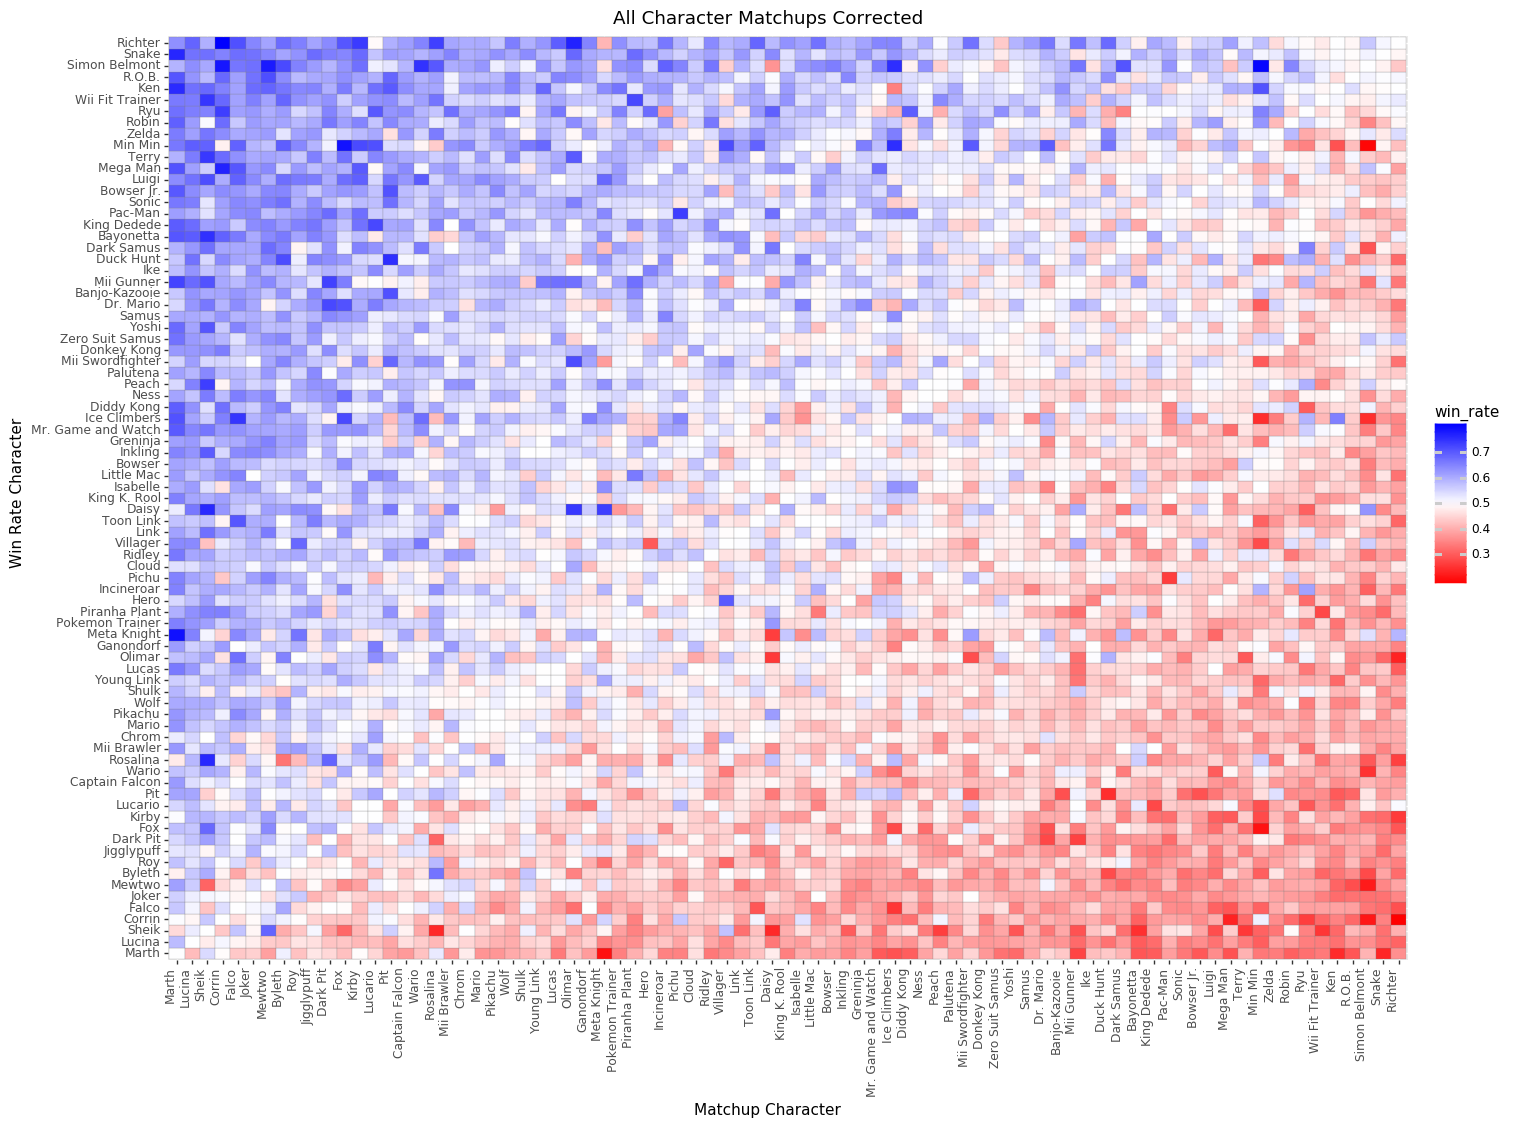

<ggplot: (8740341848265)>

In [14]:
plotnine.options.figure_size = (16, 12)
plot = ggplot(clean_matchup_df, aes(x='char2_cat', y='char1_cat', fill='win_rate')) 
plot += geom_tile(color='grey')
plot = plot + theme(axis_text_x=element_text(rotation=90, hjust=1))
plot += xlab('Matchup Character')
plot += ylab('Win Rate Character')
plot += ggtitle('All Character Matchups Corrected')
plot += scale_fill_gradient2(
  low = "#ff0000",
  med = "#ffffff",
  high = "#0000ff",
  midpoint = .5
)
plot

In [15]:
clean_matchup_df = matchup_df[matchup_df['char1'] != 'Random']
clean_matchup_df = clean_matchup_df[clean_matchup_df['char2'] != 'Random']
clean_matchup_df = clean_matchup_df[clean_matchup_df['games_played'] > 50]

clean_matchup_df

,char1,char2,win_rate,games_played,char1_overall_win_rate,char2_overall_win_rate,char1_cat,char2_cat
6599,Marth,Marth,0.500000,290,0.398496,0.398496,Marth,Marth
6586,Marth,Lucina,0.422566,452,0.398496,0.410821,Marth,Lucina
6565,Marth,Corrin,0.496403,139,0.398496,0.427257,Marth,Corrin
6598,Marth,Falco,0.436364,165,0.398496,0.428867,Marth,Falco
6557,Marth,Joker,0.444685,461,0.398496,0.431934,Marth,Joker
...,...,...,...,...,...,...,...,...
2468,Richter,Ken,0.500000,220,0.601062,0.575363,Richter,Ken
2407,Richter,R.O.B.,0.490683,483,0.601062,0.576046,Richter,R.O.B.
2462,Richter,Simon Belmont,0.562914,151,0.601062,0.584380,Richter,Simon Belmont
2465,Richter,Snake,0.509985,651,0.601062,0.586653,Richter,Snake


/home/heil/anaconda3/lib/python3.7/site-packages/plotnine/scales/scale.py:91: PlotnineWarning: scale_fill_gradient2 could not recognise parameter `med`
  warn(msg.format(self.__class__.__name__, k), PlotnineWarning)


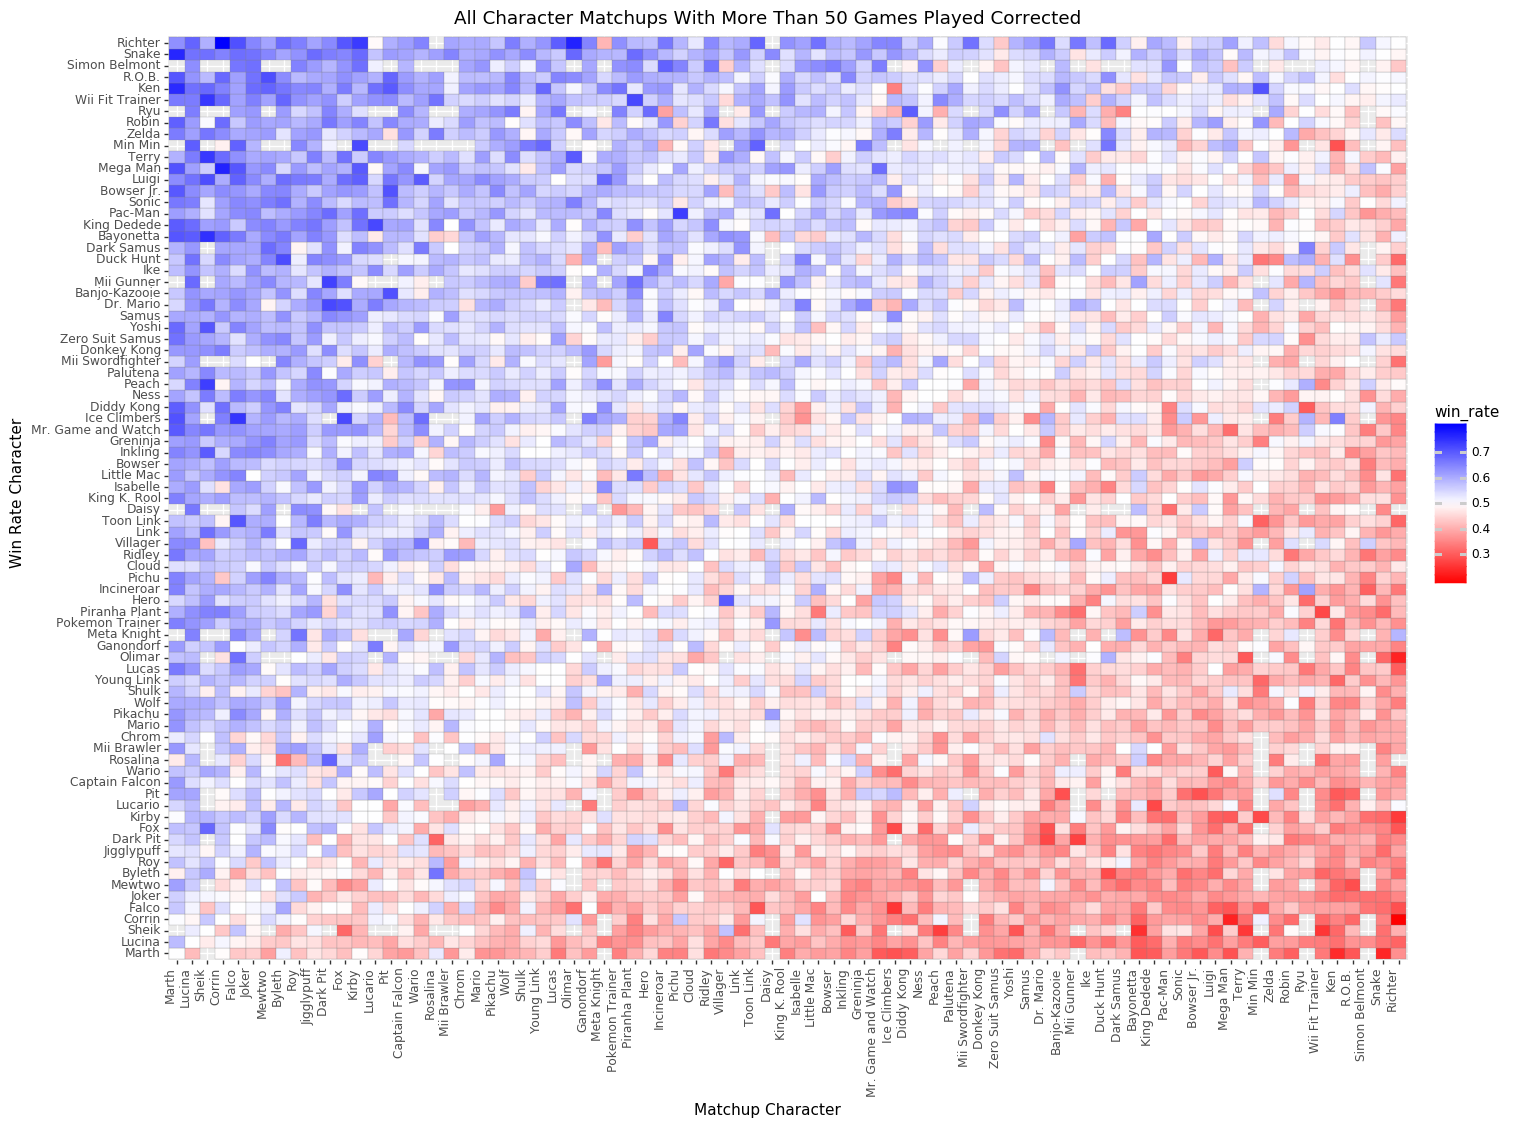

<ggplot: (8740338926021)>

In [16]:
plotnine.options.figure_size = (16, 12)
plot = ggplot(clean_matchup_df, aes(x='char2_cat', y='char1_cat', fill='win_rate')) 
plot += geom_tile(color='grey')
plot = plot + theme(axis_text_x=element_text(rotation=90, hjust=1))
plot += xlab('Matchup Character')
plot += ylab('Win Rate Character')
plot += ggtitle('All Character Matchups With More Than 50 Games Played Corrected')
plot += scale_fill_gradient2(
  low = "#ff0000",
  med = "#ffffff",
  high = "#0000ff",
  midpoint = .5
)
plot

In [17]:
matchup_df[matchup_df['char1'] == 'Bowser'].sort_values('win_rate')

,char1,char2,win_rate,games_played,char1_overall_win_rate,char2_overall_win_rate,char1_cat,char2_cat
2009,Bowser,Simon Belmont,0.349282,209,0.510731,0.584380,Bowser,Simon Belmont
2035,Bowser,Mega Man,0.389430,719,0.510731,0.553664,Bowser,Mega Man
2011,Bowser,Richter,0.405941,606,0.510731,0.601062,Bowser,Richter
2062,Bowser,Duck Hunt,0.420000,450,0.510731,0.544179,Bowser,Duck Hunt
2004,Bowser,Snake,0.422802,2377,0.510731,0.586653,Bowser,Snake
...,...,...,...,...,...,...,...,...
2057,Bowser,Falco,0.579181,903,0.510731,0.428867,Bowser,Falco
2066,Bowser,Lucina,0.596885,1605,0.510731,0.410821,Bowser,Lucina
2072,Bowser,Marth,0.606481,432,0.510731,0.398496,Bowser,Marth
2041,Bowser,Corrin,0.611354,458,0.510731,0.427257,Bowser,Corrin


## Stage Analysis

In [18]:
stages_df = games_df.dropna()

In [19]:
stages_df.head()

,char1,char2,stage,winner,entrant1,entrant2
0,Lucina,Ness,Pokémon Stadium 2,Ness,KG | Jegerlilla,RES | Venom
1,Ness,Lucina,Smashville,Ness,RES | Venom,KG | Jegerlilla
2,Ness,Lucina,Battlefield,Ness,RES | Venom,KG | Jegerlilla
3,Banjo-Kazooie,Young Link,Final Destination,Banjo-Kazooie,RoA | Irish_Penguin,LazZzy
4,Banjo-Kazooie,Young Link,Final Destination,Banjo-Kazooie,RoA | Irish_Penguin,LazZzy


In [20]:
legal_stages = set(['Pokémon Stadium 2', 'Smashville', 'Battlefield', 'Final Destination',
                    'Kalos Pokémon League', 'Lylat Cruise', 'Town and City',
                    "Yoshi's Story"
                   ])

stage_wins = {}
stage_losses = {}

for _, row in stages_df.iterrows():
    char1 = row['char1']
    char2 = row['char2']
    winner = row['winner']
    stage = row['stage']
    
    if stage not in legal_stages:
        continue
    
    if char1 == char2: 
        continue
        
    if char1 != winner:
        char1, char2 = (char2, char1)
    
    if stage in stage_wins:
        if char1 in stage_wins[stage]:
            stage_wins[stage][char1] += 1
        else:
            stage_wins[stage][char1] = 1
    else:
        stage_wins[stage] = {}
        stage_wins[stage][char1] = 1
            
    if stage in stage_losses:
        if char2 in stage_losses[stage]:
            stage_losses[stage][char2] += 1
        else:
            stage_losses[stage][char2] = 1
    else:
        stage_losses[stage] = {}
        stage_losses[stage][char2] = 1

In [21]:
winrate_info = {'char': [], 'stage': [], 'character_winrate': [],
                    'stage_winrate': [], 'games_played': []}

for stage in stage_wins:
    for char in stage_wins[stage]:
        if stage not in stage_losses or char not in stage_losses[stage]:
            continue
        wins = stage_wins[stage][char]
        losses = stage_losses[stage][char]
        win_rate = wins / (wins + losses)
        
        winrate_info['char'].append(char)
        winrate_info['stage'].append(stage)
        winrate_info['stage_winrate'].append(win_rate)
        winrate_info['games_played'].append(wins + losses)
        winrate_info['character_winrate'].append(char_to_win_rate[char])

In [22]:
winrate_df = pd.DataFrame.from_dict(winrate_info)

In [23]:
winrate_df['stage_benefit'] = winrate_df['stage_winrate'] - winrate_df['character_winrate'] 
winrate_df

,char,stage,character_winrate,stage_winrate,games_played,stage_benefit
0,Ness,Pokémon Stadium 2,0.523139,0.510915,27484,-0.012223
1,Wolf,Pokémon Stadium 2,0.486827,0.473911,29763,-0.012916
2,Snake,Pokémon Stadium 2,0.586653,0.586871,25912,0.000218
3,Mario,Pokémon Stadium 2,0.481536,0.483380,20878,0.001844
4,Kirby,Pokémon Stadium 2,0.458097,0.435851,8753,-0.022246
...,...,...,...,...,...,...
651,Pit,Yoshi's Story,0.463574,0.469027,339,0.005452
652,Simon Belmont,Yoshi's Story,0.584380,0.600000,150,0.015620
653,Marth,Yoshi's Story,0.398496,0.387528,449,-0.010968
654,Random,Yoshi's Story,0.433764,0.412371,194,-0.021392


/home/heil/anaconda3/lib/python3.7/site-packages/plotnine/scales/scale.py:91: PlotnineWarning: scale_fill_gradient2 could not recognise parameter `med`
  warn(msg.format(self.__class__.__name__, k), PlotnineWarning)


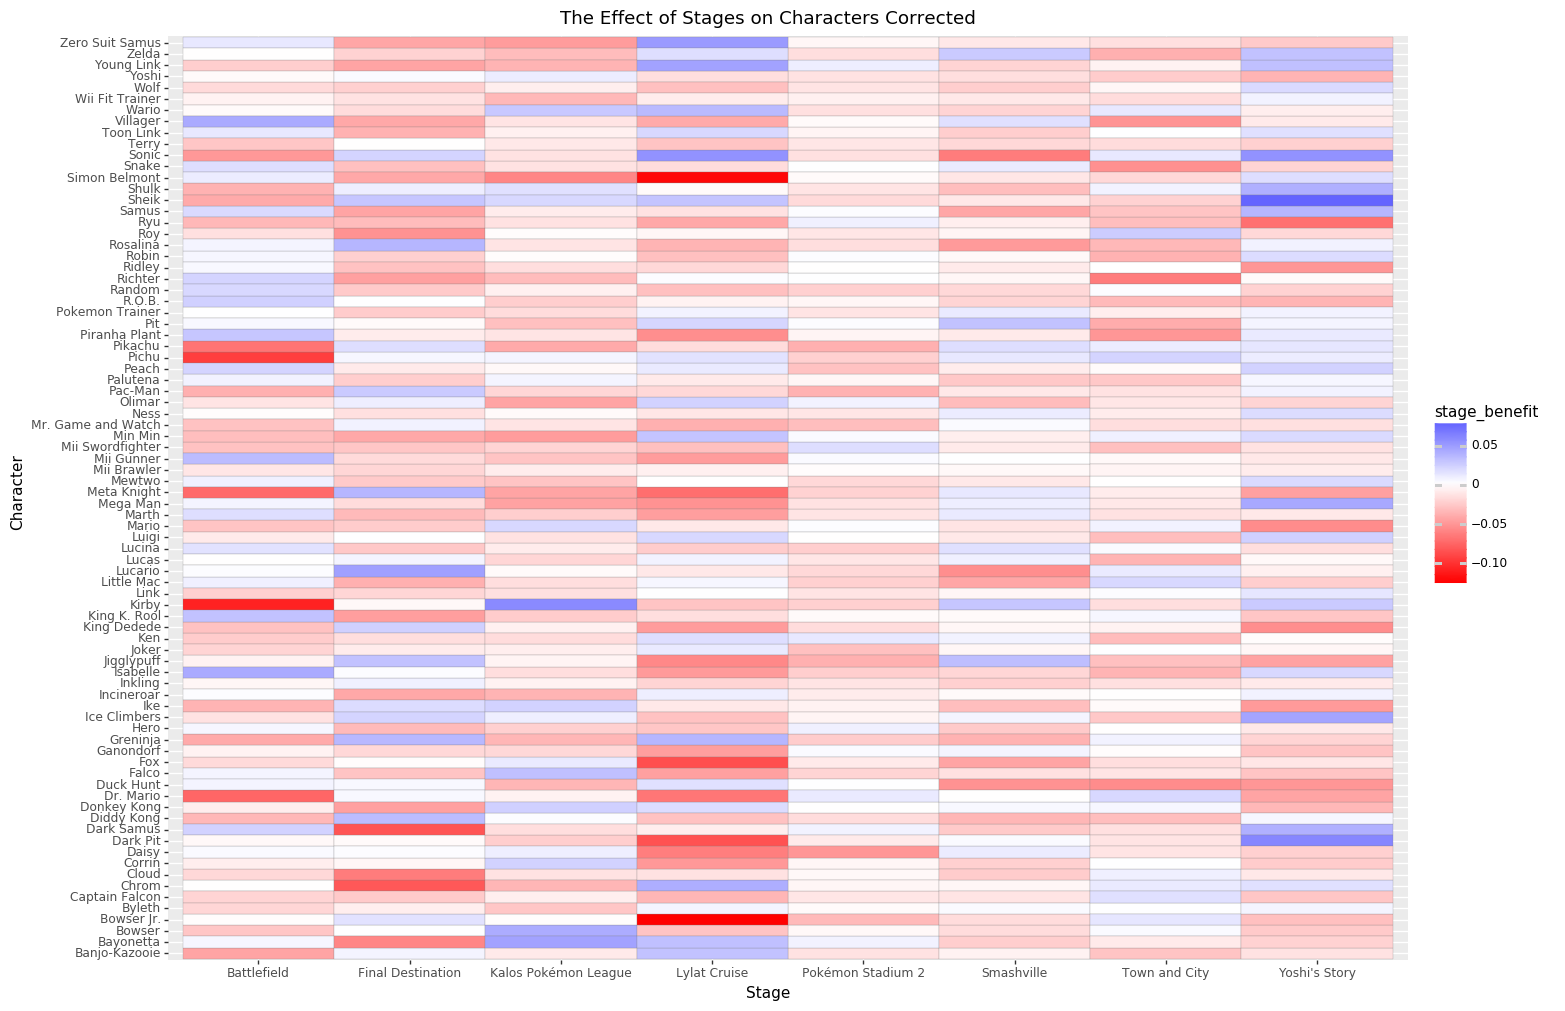

<ggplot: (8740341904017)>

In [24]:
plot =ggplot(winrate_df, aes(x='stage', y='char', fill='stage_benefit')) + geom_tile(color='grey') 
plot += xlab('Stage')
plot += ylab('Character')
plot += ggtitle('The Effect of Stages on Characters Corrected')
plot += scale_fill_gradient2(
  low = "#ff0000",
  med = "#ffffff",
  high = "#0000ff",
)
plot

In [25]:
winrate_df[winrate_df['char'] == 'Bowser']

,char,stage,character_winrate,stage_winrate,games_played,stage_benefit
17,Bowser,Pokémon Stadium 2,0.510731,0.507438,26484,-0.003292
111,Bowser,Smashville,0.510731,0.493948,10906,-0.016783
196,Bowser,Battlefield,0.510731,0.484002,11283,-0.026728
273,Bowser,Final Destination,0.510731,0.511009,11082,0.000278
337,Bowser,Kalos Pokémon League,0.510731,0.549917,7272,0.039187
415,Bowser,Lylat Cruise,0.510731,0.482808,2094,-0.027923
513,Bowser,Town and City,0.510731,0.512988,12858,0.002257
606,Bowser,Yoshi's Story,0.510731,0.485881,4108,-0.024850


In [26]:
winrate_df.sort_values('stage_benefit')

,char,stage,character_winrate,stage_winrate,games_played,stage_benefit
436,Bowser Jr.,Lylat Cruise,0.552898,0.432039,206,-0.120859
435,Simon Belmont,Lylat Cruise,0.584380,0.466667,180,-0.117713
212,Kirby,Battlefield,0.458097,0.353837,1642,-0.104260
180,Pichu,Battlefield,0.497533,0.406857,1750,-0.090676
475,Fox,Lylat Cruise,0.454470,0.370933,461,-0.083538
...,...,...,...,...,...,...
637,Sonic,Yoshi's Story,0.551659,0.603239,1729,0.051580
421,Sonic,Lylat Cruise,0.551659,0.603321,1084,0.051662
365,Kirby,Kalos Pokémon League,0.458097,0.513240,2077,0.055144
615,Dark Pit,Yoshi's Story,0.450310,0.507143,420,0.056832


In [27]:
winrate_df = winrate_df.sort_values(['stage', 'char'])
winrate_df.to_csv('stage_stats.csv', index=False, float_format='%.3f')

In [28]:
wolf_df = matchup_df[matchup_df['char1'] == 'Wolf']
wolf_df[wolf_df['char2'] == 'Jigglypuff']

,char1,char2,win_rate,games_played,char1_overall_win_rate,char2_overall_win_rate,char1_cat,char2_cat
299,Wolf,Jigglypuff,0.54756,1209,0.486827,0.447899,Wolf,Jigglypuff
